In [ ]:
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_hub as tf_hub
import numpy as np
import librosa

from qdrant_client import QdrantClient
from qdrant_client.http.models import Distance, VectorParams, PointStruct, Filter, FieldCondition, MatchValue
from qdrant_client.http import models

import requests
import sys
import random
import time

In [ ]:
client = QdrantClient(
    "192.168.178.68",
    port=6333
)

fmusic_url = "http://192.168.178.68:8675"

In [ ]:
vector_config = VectorParams(size=521, distance=Distance.COSINE)

try:
    client.create_collection(collection_name="fmusic", vector_params=vector_config)
except:
    pass

In [ ]:
model_url = "https://tfhub.dev/google/yamnet/1"
model = tf_hub.load(model_url)

In [ ]:
def get_embeddings(file_path: str) -> list[float]:
    audio, sr = librosa.load(file_path, sr=None, mono=True)
    embeddings = model(audio)
    #embeddings: [tensorflow.python.framework.ops.EagerTensor, tensorflow.python.framework.ops.EagerTensor, tensorflow.python.framework.ops.EagerTensor]
    #first tensor is the embeddings
    #second tensor is the spectrogram
    #third tensor is the log mel spectrogram
    
    #convert embeddings to numpy array
    embeddings = np.array(embeddings[0])
    
    #convert numpy array to list
    embeddings = embeddings.tolist()
    return embeddings

def audio_to_np_arr(audio: bytes) -> np.array:
    #audio is a mp3 or flac file
    
    #Ensure the audio bytes array size is a multiple of 2 (size of int16)
    if len(audio) % 2 != 0:
        audio = audio[:-1]
    
    audio = np.frombuffer(audio, dtype=np.int16)

    audio = audio.astype(np.float32) / 32768.0
    
    return audio

def splice_arr(arr: np.array, max_size: int) -> list[np.array]:
    #arr is a numpy array
    #max_size is the max length of the returned arrays
    
    #split the array into multiple arrays with max_size
    #return a list of arrays
    
    if len(arr) <= max_size:
        return [arr]
    
    #calculate the number of arrays
    num_arrays = len(arr) // max_size
    if len(arr) % max_size != 0:
        num_arrays += 1
    
    #create the arrays
    arrays = []
    for i in range(num_arrays):
        arrays.append(arr[i * max_size:(i + 1) * max_size])
    
    return arrays

def get_embeddings_from_np_arr(audio: np.array) -> list[float]:
    embeddings = model(audio)
    
    #convert embeddings to numpy array
    embeddings = np.array(embeddings[0])
    
    #convert numpy array to list
    embeddings = embeddings.tolist()
    return embeddings

def get_embeddings_from_audio(audio: bytes) -> list[float]:
    #audio is a mp3 or flac file
    
    #Ensure the audio bytes array size is a multiple of 2 (size of int16)
    if len(audio) % 2 != 0:
        audio = audio[:-1]
    
    audio = np.frombuffer(audio, dtype=np.int16)

    audio = audio.astype(np.float32) / 32768.0
    
    
    embeddings = model(audio)
    
    #convert embeddings to numpy array
    embeddings = np.array(embeddings[0])
    
    #convert numpy array to list
    embeddings = embeddings.tolist()
    return embeddings

def get_audio(audio_id) -> bytes:
    url = f"{fmusic_url}/api/song/{audio_id}"
    
    r = requests.get(url)
    
    return r.content

def get_audio_without_size_limit(audio_id) -> bytes:
    #fix for error:
    #b'{"status":{"error":"Payload error: JSON payload (34757135 bytes) is larger than allowed (limit: 33554432 bytes)."},"time":0.0}
    
    url = f"{fmusic_url}/api/song/{audio_id}"
    
    max_timeout = 30 #seconds
    max_filesize_MB = 100 #MB
    
    #set max json payload size to 100MB
    r = requests.get(url, headers={"Content-Type": "audio/mpeg", "Content-Length": str(max_filesize_MB * 1024 * 1024)}, timeout=max_timeout)
    
    return r.content
    

def get_max_id() -> int:
    url = f"{fmusic_url}/api/get_num_songs"
    
    r = requests.get(url)
    
    return r.json()["num_songs"]

In [ ]:
def add_vectors_to_db(vectors: list[list[float]], id: int):
    #3505 vectors = 39.5MB
    #max 33554432 bytes = 32MB
    
    if len(vectors) > 2000:
        #cut into chunks of 2000 vectors
        chunks = [vectors[x:x+2000] for x in range(0, len(vectors), 2000)]
        
        for chunk in chunks:
            add_vectors_to_db(chunk, id)
        
        return
    
    
    points = []
    
    for idx, vector in enumerate(vectors):
        point_id = id * 10000
        point_id += idx
        
        point = PointStruct(
            id=point_id,
            vector=vector,
            payload={"id": id}
        )
        
        points.append(point)
    
    op = client.upsert(
        collection_name="fmusic",
        points=points
    )
    
    return op
    

def song_is_in_vector_db(song_id):

    res = client.search(
        collection_name="fmusic",
        query_vector=[0.0] * 521,
        query_filter=Filter(
            must=[FieldCondition(
                key="id",
                match=MatchValue(value=song_id)
            )]
        ),
        limit=1
    )

    return len(res) > 0

def song_is_in_vector_db_2(song_id):
    #vector ids are 10000 * song_id + idx
    
    id = song_id * 10000 + 1
    
    res = client.retrieve(
        collection_name="fmusic",
        ids=[id]
    )
    
    return len(res) > 0

def vector_is_in_vector_db(vector_id):
    #vector ids are 10000 * song_id + idx
    
    id = vector_id
    
    res = client.retrieve(
        collection_name="fmusic",
        ids=[id]
    )
    
    return len(res) > 0
    

def time_to_str(t:float) -> str:
    #convert time in seconds to ns, ms, s, m, h, d, y
    # depending on the size of the time
    
    if t < 1e-9:
        t = t * 1e12
        suffix = "ps"
    elif t < 1e-6:
        t = t * 1e9
        suffix = "ns"
    elif t < 1e-3:
        t = t * 1e6
        suffix = "µs"
    elif t < 1:
        t = t * 1e3
        suffix = "ms"
    elif t < 60:
        suffix = "s"
    elif t < 3600:
        t = t / 60
        suffix = "m"
    elif t < 86400:
        t = t / 3600
        suffix = "h"
    elif t < 31536000:
        t = t / 86400
        suffix = "d"
    elif t >= 31536000:
        t = t / 31536000
        suffix = "y"
    else:
        t = t
        suffix = "s"
    
    return f"{t:.2f} {suffix}"

In [ ]:
def get_recomendations(song_id, threshhold=1, n_results=100, verbose=False) -> list[tuple[int, int]]:
    #@param song_id: the id of the song to get the recomendations for
    #@param threshhold: the minimum number of times a song has to be found to be included in the result
    #@param n_results: the n nearest vectors to search for for each vector
    #@param verbose: print the time it took to perform the operations and the progress
    
    
    t_start = time.time()
    
    min_vector_id = song_id * 10000
    max_possible_vector_id = min_vector_id + 9999
    
    # Binary search to find the maximum vector ID in the database
    lower_bound = min_vector_id
    upper_bound = max_possible_vector_id
    max_vector_id = None
    
    while lower_bound <= upper_bound:
        mid = (lower_bound + upper_bound) // 2
        
        if vector_is_in_vector_db(mid):
            max_vector_id = mid
            lower_bound = mid + 1
        else:
            upper_bound = mid - 1
    
    # Now you can use the max_vector_id to perform further operations
    
    
    
    vector_ids = list(range(min_vector_id, max_vector_id + 1))
    
    
    #get the vectors from the db
    res = client.retrieve(
        collection_name="fmusic",
        ids=vector_ids,
        with_vectors=True
    )
    
    vectors = []
    for vector in res:
        vectors.append(vector.vector)
    
    t_end_get_vectors = time.time()

    
    song_ids = {} #id: count
    
    
    #setup batch search
    search_queries = []
    for idx, vector in enumerate(vectors):
        query = models.SearchRequest(
            vector=vector,
            limit=n_results,
            with_payload=True
        )
        search_queries.append(query)
        
        if len(search_queries) >= 100:
            res = client.search_batch(
                collection_name="fmusic",
                requests=search_queries
            ) #-> [[ScoredPoint, ScoredPoint, ...], [ScoredPoint, ScoredPoint, ...], ...]
            
            for arr in res:
                for point in arr:
                    id = point.payload["id"]
                    if id not in song_ids:
                        song_ids[id] = 0
                    song_ids[id] += 1
            
            search_queries = []
                    

        if verbose:
            print(f"{idx} / {len(vectors)}", end="\r")
    
    if len(search_queries) > 0:
        res = client.search_batch(
            collection_name="fmusic",
            requests=search_queries
        )
        
        for arr in res:
            for point in arr:
                id = point.payload["id"]
                if id not in song_ids:
                    song_ids[id] = 0
                song_ids[id] += 1
    
    
    
    
    t_end_search = time.time()
    
    if song_id in song_ids:
        del song_ids[song_id]
    
    #sort the song ids by count
    song_ids = sorted(song_ids.items(), key=lambda x: x[1], reverse=True)
    
    #cut of the song ids with a count lower than threshhold
    song_ids = [x for x in song_ids if x[1] >= threshhold]
    
    t_end_filter = time.time()
    
    
    if verbose:
        print(" " * 80)
        print(f"params: id={song_id}, threshhold={threshhold}, n_results={n_results}")
        print()
        print(f"get vectors: {time_to_str(t_end_get_vectors - t_start)}")
        print(f"search: {time_to_str(t_end_search - t_end_get_vectors)} ({time_to_str((t_end_search - t_end_get_vectors) / len(vectors))} per vector)")
        print(f"filter: {time_to_str(t_end_filter - t_end_search)}")
        print(f"total: {time_to_str(t_end_filter - t_start)}")
    
    #return the song ids
    return song_ids #list of tuples (id, count)
    

                                                                                
params: id=8187, threshhold=1, n_results=100

get vectors: 720.56 ms
search: 11.48 s (10.61 ms per vector)
filter: 8.54 ms
total: 12.21 s


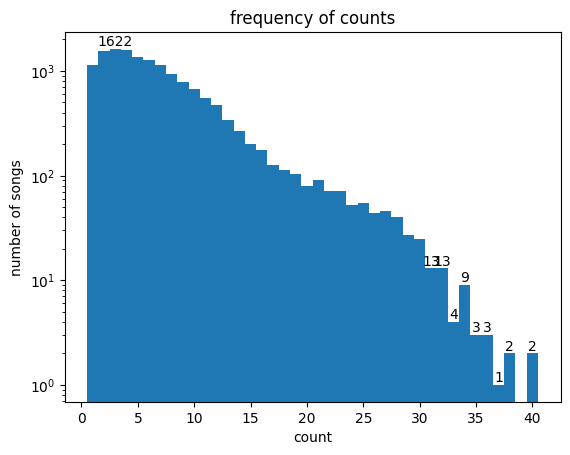

https://fmusic.linushorn.dev/song/4628
https://fmusic.linushorn.dev/song/7561
https://fmusic.linushorn.dev/song/153
https://fmusic.linushorn.dev/song/7505
https://fmusic.linushorn.dev/song/305
https://fmusic.linushorn.dev/song/1020
https://fmusic.linushorn.dev/song/2044
https://fmusic.linushorn.dev/song/4673
https://fmusic.linushorn.dev/song/789
https://fmusic.linushorn.dev/song/25


In [134]:
#temp, manual stuff

id = 8187

closest = get_recomendations(id, threshhold=1, n_results=100, verbose=True)
#(id, count), (id, count), ...

counts = []
for song_id, count in closest:
    counts.append(count)

frequency = {} #count: number of songs
for count in counts:
    if count not in frequency:
        frequency[count] = 0
    frequency[count] += 1



plt.bar(frequency.keys(), frequency.values(), width=1)
plt.xlabel("count")
plt.ylabel("number of songs")
plt.title("frequency of counts")

plt.yscale("log")

#add numbers to the bars
max_value = max(frequency.values())

for x, y in frequency.items():
    if y < 20 or y == max_value:
        plt.text(x, y, str(y), ha="center", va="bottom")
    else:
        continue



plt.show()

for song_id, count in closest[:10]:
    url = "https://fmusic.linushorn.dev/song/" + str(song_id)
    print(url)

In [ ]:
max_id = get_max_id()


times = []

for i in range(max_id):
    t_start = time.time()
    
    try:
        song_is_in_db = song_is_in_vector_db_2(i)
        #print(song_is_in_db)
    except Exception as e:
        print(e, "Didnt work")
        song_is_in_db = False
    
    if song_is_in_db:
        print(f"Song with id {i} is already in db")
        continue
    
    try:
        audio = get_audio_without_size_limit(i)
        
        t_end_download = time.time()
        
        arr = audio_to_np_arr(audio)
        sub_arrs = splice_arr(arr, 25_000_000) #25 million
        
        if len(sub_arrs) != 1:
            print(f"Song with id {i} is too long, splitting into {len(sub_arrs)} arrays")
        
        embeddings = []
        
        for sub_arr in sub_arrs:
            embeddings += get_embeddings_from_np_arr(sub_arr)
        
        t_end_calc = time.time()
        
        add_vectors_to_db(embeddings, i)
        
        t_end_vector_db = time.time()
        
    except Exception as e:
        print(e)
        print(f"Failed to add song with id {i}")
        continue
    
    
    t_end = time.time()
    total_time = t_end - t_start
    download_time = t_end_download - t_start
    calc_time = t_end_calc - t_end_download
    vector_db_time = t_end_vector_db - t_end_calc
        
    times.append(total_time)
    
    avg_time_per_song = sum(times) / len(times)
    songs_remaining = max_id - i
    ttg = avg_time_per_song * songs_remaining
    print(f"{i}/{max_id} - Total: {time_to_str(total_time)} (Download: {time_to_str(download_time)}, Calc: {time_to_str(calc_time)}, Vector DB: {time_to_str(vector_db_time)}) TTG: {time_to_str(ttg)}" + " " * 15, end="\r")

